### Read CSV file

In [1]:
import pandas as pd
df = pd.read_csv("emails.csv")
df.shape

(517401, 2)

In [2]:
df.sample(3)

,file,message
67924,dasovich-j/deleted_items/1861.,Message-ID: <17741028.1075861476545.JavaMail.e...
34655,blair-l/meetings/273.,Message-ID: <19928767.1075853031043.JavaMail.e...
117509,fossum-d/discussion_threads/251.,Message-ID: <10261155.1075842459729.JavaMail.e...


### Extract text

In [3]:
def text_extraction(message):
    text_list = message.splitlines()[15:]
    clean_text = list(filter(None, text_list))
    text_string = ''.join(clean_text)
    return text_string

In [4]:
df['text'] = df['message'].apply(text_extraction)

In [5]:
df.head(3)

,file,message,text
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!


### Drop unused columns and rows

In [6]:
df = df.drop(['file','message'],axis=1)
df = df.drop_duplicates()

### Text Preprocess

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
import re

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    global lemmatizer , stemmer , stop_words
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[@#]', '', text)

    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens]
    
    text = ' '.join(tokens)
    
    return text

In [8]:
df['text'] = df['text'].apply(preprocess_text)

In [9]:
df = df.reset_index(drop=True)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
text_features = tfidf_vectorizer.fit_transform(df['text'])

In [11]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2)
features = svd.fit_transform(text_features)

Text(0.5, 1.0, 'Data Before Clustering')

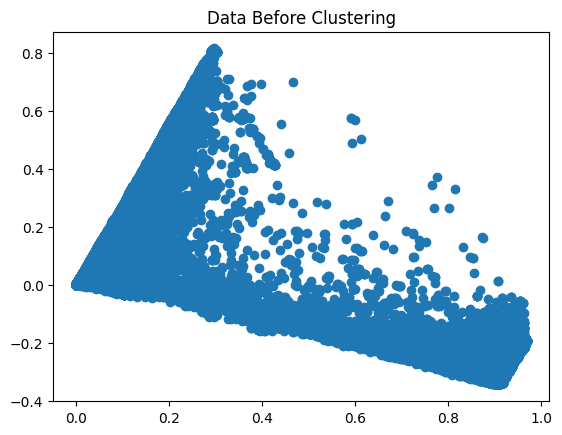

In [12]:
import matplotlib.pyplot as plt

plt.scatter(features[:, 0], features[:, 1])
plt.title('Data Before Clustering')

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(text_features)

c:\Users\kazem\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [14]:
df['clusters'] = clusters
df["clusters"].value_counts()

clusters
1    294546
0     18420
Name: count, dtype: int64

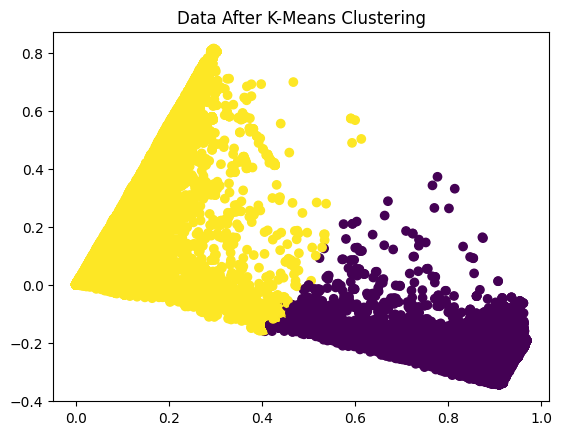

In [15]:
plt.scatter(features[:, 0], features[:, 1], c=clusters)
plt.title('Data After K-Means Clustering')
plt.show()

In [17]:
cluster_features = {}

cluster_centers = kmeans.cluster_centers_

for cluster_id in range(kmeans.n_clusters):
    cluster_center = cluster_centers[cluster_id]

    top_feature_indices = cluster_center.argsort()[::-1][:50]
    top_features = [tfidf_vectorizer.get_feature_names_out()[idx] for idx in top_feature_indices]
    cluster_features[cluster_id] = top_features

for cluster_id, top_features in cluster_features.items():
    print(f"Cluster {cluster_id} top features: {', '.join(top_features)}")

Cluster 0 top features: cn, recipients, ou, na, enron, com, pdavi, pete, notesaddr, davi, ryan, solberg, non, schedul, privileg, john, meyer, iii, bcc, william, cdean, to, cc, mark, geir, dean, folder, bill, hourahead, from, albert, comx, exmerg, dbcapsdata, craig, bwillia, origin, michael, final, mguzman, rsling, gsolb, bmey, slinger, itemsx, filenam, eu, mmi, jand, mier
Cluster 1 top features: com, hou, origin, ectect, enron, pleas, thank, messag, sent, filenam, mail, subject, would, know, from, enronenron, get, call, time, need, corp, mark, pm, attach, let, forward, meet, go, deal, pmto, may, ga, work, new, not, market, power, day, folder, energi, like, cc, john, email, price, inform, jeff, trade, agreement, see
